In [7]:
 # Copyright 2023 Akvelon Inc.
 #
 # Licensed to the Apache Software Foundation (ASF) under one
 # or more contributor license agreements.  See the NOTICE file
 # distributed with this work for additional information
 # regarding copyright ownership.  The ASF licenses this file
 # to you under the Apache License, Version 2.0 (the
 # "License"); you may not use this file except in compliance
 # with the License.  You may obtain a copy of the License at
 #
 #     http://www.apache.org/licenses/LICENSE-2.0
 #
 # Unless required by applicable law or agreed to in writing, software
 # distributed under the License is distributed on an "AS IS" BASIS,
 # WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 # See the License for the specific language governing permissions and
 # limitations under the License.

In [ ]:
import tensorflow as tf
import apache_beam as beam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import category_encoders as ce

from apache_beam import dataframe
from apache_beam.ml.inference.base import RunInference
from apache_beam.runners.interactive.interactive_runner import InteractiveRunner
from tensorflow import keras
from tensorflow.keras import layers

import apache_beam.runners.interactive.interactive_beam as ib

Create a processor that will map the input features to examples from tf

In [5]:
class ExampleProcessor:
    def create_example_with_label(self, feature: np.float32,
                                  label: np.float32)-> tf.train.Example:
        return tf.train.Example(
            features=tf.train.Features(
                feature={'x': self.create_feature(feature),
                         'y' : self.create_y(label)
                         }))

    def create_example(self, feature: np.float32):
        return tf.train.Example(
            features=tf.train.Features(
                feature={'x' : self.create_feature(feature)}
                         # 'Id' : self.create_id(id)})
            ))

    def create_feature(self, element):
        return tf.train.Feature(float_list=tf.train.FloatList(value=element))

    def create_id(self, element):
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[element]))

    def create_y(self, element):
        return tf.train.Feature(float_list=tf.train.FloatList(value=[element]))

In [9]:
hasher = ce.HashingEncoder(n_components=64, max_process=1, max_sample=1)

def hash_encode(element, id='Id'):
    result = [getattr(element, k) for k in set(element._fields) - {'CreatedDate', 'CloseDate', id}]
    hashed_list = hasher.fit_transform(np.asarray([result]))
    return hashed_list.to_numpy()
    # return element.Id, hashed_list.to_numpy()

def add_target_date_and_encode(element, id='Id'):
    # Taking rstrip of trailing Z timezone
    created_date = datetime.datetime.strptime(getattr(element, 'CreatedDate').rstrip('Z'), '%Y-%m-%dT%H:%M:%S.%f')
    closed_date = datetime.datetime.strptime(getattr(element, 'CloseDate'), '%m/%d/%y')
    hashed_list = hash_encode(element, id)
    # _, hashed_list = hash_encode(element, id)
    return (closed_date - created_date).days, hashed_list

In [10]:
train_tfrec = 'train_op.tfrecord'
test_tfrec = 'test_op.tfrecord'

##### Train data preprocessing pipeline
loads train/test data and preprocess it

In [11]:
def process_data():
    dfs = []
    for csv in ('../data/dtc_opportunity_train.csv', '../data/dtc_opportunity_test.csv'):
        with beam.Pipeline(InteractiveRunner()) as p:
            input_data = p | "Read CSV" >> beam.dataframe.io.read_csv(csv)
            # For now dropping dates
            input_data = input_data.drop(['Billing State/Province',
                                          'Account Name',
                                          'Product Name',
                                          'Opportunity Name',
                                          'Opportunity Owner',
                                          'Account Owner'], axis=1)
            input_data = input_data.drop('#', axis=1)
            input_data = input_data.rename(columns={x: x.replace(' ', '') for x in input_data.columns})

            input_data['Id'] = input_data.index
            input_data = beam.dataframe.convert.to_pcollection(input_data)


            ready_data = (
                    input_data
                    | beam.Map(lambda df: add_target_date_and_encode(df))
            )
            dfs.append(ib.collect(ready_data))

    for i, dataframe in enumerate(dfs):
        if i == 0:
            name = 'train'
        else:
            name = 'test'
        with tf.io.TFRecordWriter(f'{name}.tfrecord') as writer:
            for label, feature in zip(dataframe[0], dataframe[1]):
                example = ExampleProcessor().create_example_with_label(
                    feature=feature[0], label=label)
                writer.write(example.SerializeToString())
    return dfs

In [12]:
aa = process_data()

In [13]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

##### Define keras model

In [14]:
def build_and_compile_model(shape):
  model = keras.Sequential([
      layers.Input(shape=(shape,), name='x'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

##### Features to tfrecord dataset of examples

In [15]:
RAW_DATA_TRAIN_SPEC = {
    'x': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
    'y': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True)
}

train_dataset = tf.data.TFRecordDataset('train.tfrecord')
train_dataset = train_dataset.map(lambda e : tf.io.parse_example(e, RAW_DATA_TRAIN_SPEC))
train_dataset = train_dataset.map(lambda t : (t['x'], t['y']))
train_dataset = train_dataset.batch(1)
train_dataset = train_dataset.repeat()

test_dataset = tf.data.TFRecordDataset('train.tfrecord')
test_dataset = test_dataset.map(lambda e : tf.io.parse_example(e, RAW_DATA_TRAIN_SPEC))
test_dataset = test_dataset.map(lambda t : (t['x'], t['y']))
test_dataset = test_dataset.batch(1)


dnn_model = build_and_compile_model(shape=64)
dnn_model.build()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [16]:
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,385
Trainable params: 8,385
Non-trainable params: 0
_________________________________________________________________


##### Fit the model
Starts the training

In [17]:
history = dnn_model.fit(
    train_dataset,
    validation_data=test_dataset,
    steps_per_epoch=8,
    verbose=0, epochs=40)

##### Plot loss graph

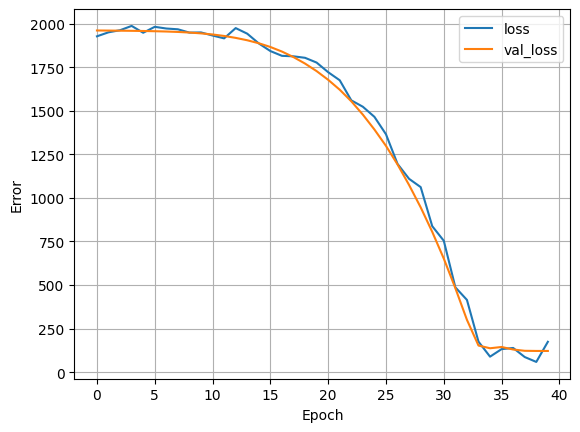

In [18]:
plot_loss(history)

##### Save the trained model

In [20]:
from tfx_bsl.public.beam.run_inference import CreateModelHandler
from tfx_bsl.public.proto import model_spec_pb2

In [21]:
RAW_DATA_PREDICT_SPEC = {
    'x': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
    # 'Id': tf.io.FixedLenFeature([], tf.string)
}


@tf.function(input_signature=[tf.TensorSpec(shape=[None], dtype=tf.string)])
def serve_tf_examples_fn(data):
    print(data.shape)
    features = tf.io.parse_example(data, RAW_DATA_PREDICT_SPEC)
    """Returns the output to be used in the serving signature."""
    return dnn_model(features, training=False)
    # return features['Id'], dnn_model(features['x'], training=False)

signature = {'serving_default': serve_tf_examples_fn}

In [22]:
tf.keras.models.save_model(dnn_model, 'pretrained/tf_regressor', signatures=signature)

(None,)


INFO:tensorflow:Assets written to: pretrained/tf_regressor\assets


INFO:tensorflow:Assets written to: pretrained/tf_regressor\assets


##### Output format function

In [25]:
class FormatOutput(beam.DoFn):
    def process(self, element):
        predict_log = element.predict_log
        input_value = tf.train.Example.FromString(predict_log.request.inputs['data'].string_val[0])
        input_float_value = input_value.features.feature['x'].float_list
        output_value = predict_log.response.outputs
        output_float_value = output_value['output_0'].float_val[0]
        yield f"example is {str(input_float_value)} prediction is {str(output_float_value)}"

### Inference pipeline

In [26]:
saved_model_spec = model_spec_pb2.SavedModelSpec(model_path='pretrained/tf_regressor')
inference_spec_type = model_spec_pb2.InferenceSpecType(saved_model_spec=saved_model_spec)
model_handler = CreateModelHandler(inference_spec_type)


with beam.Pipeline(InteractiveRunner()) as p:
    data = (p | "Read CSV" >> beam.dataframe.io.read_csv('../anomaly_detection/dtc_opportunity_test.csv'))
    data = data.drop(['Billing State/Province',
                                  'Account Name',
                                  'Product Name',
                                  'Opportunity Name',
                                  'Opportunity Owner',
                                  'Account Owner'], axis=1)
    data = data.drop('#', axis=1)
    data = data.rename(columns={x: x.replace(' ', '') for x in data.columns})
    data['Id'] = data.index

    data = beam.dataframe.convert.to_pcollection(data)

    result = (
         data
         | beam.Map(lambda df: hash_encode(df))
         | "Convert to tf.Examples" >> beam.Map(lambda x: ExampleProcessor().create_example(feature=x[0]).SerializeToString())
         | RunInference(model_handler)
         | beam.ParDo(FormatOutput())
         | beam.Map(print)
         )

INFO:tensorflow:Restoring parameters from pretrained/tf_regressor\variables\variables


INFO:tensorflow:Restoring parameters from pretrained/tf_regressor\variables\variables
